In [47]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import re
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
import tensorflow.keras.losses
import tensorflow.keras.metrics
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [48]:
%matplotlib inline
K.set_image_data_format('channels_last')
                    #initiate the variables
smooth=1.0
img_rows = 96
img_cols = 96

In [49]:
def load_images(num_img): #import all the images
    num_test=400
    Dossier_Complet= os.listdir('./train/')
    Dossier_Complet= [re.split('_|\.', i) for i in Dossier_Complet]

    original=sorted([i[:2] for i in Dossier_Complet[:num_img] if len(i)==3])
    original=['_'.join(i) for i in original]

    #set_train = [imread('./train/'+str(i)+'.tif') for i in original[:]]
    #set_mask = [imread('./train/'+str(i)+'_mask.tif') for i in original[:]]
    
    set_train = [imread('./train/'+str(i)+'.tif') for i in original[num_test:]]
    set_mask = [imread('./train/'+str(i)+'_mask.tif') for i in original[num_test:]]
    set_test = [imread('./train/'+str(i)+'.tif') for i in original[:num_test]]
    set_test_mask = [imread('./train/'+str(i)+'_mask.tif') for i in original[:num_test]]
    return set_train, set_mask, set_test, set_test_mask

def preprocessing(imgs, rows, cols, normalized=False, mask=False): #preprocessing to add one channels and to normalize
    img_1 = np.ndarray((np.asarray(imgs).shape[0],rows, cols), dtype=np.uint8)
    img_1 = np.asarray([resize(i, (rows, cols, 1), preserve_range=True) for i in imgs])
    #img_1 = img_1[..., np.newaxis]
    
    if normalized:
        img_1= (img_1/255.)#-0.5
    if mask:
        #img_1 = np.asarray([resize(i, (rows, cols, 2), preserve_range=True) for i in imgs])
        #img_1[img_1<150] = 0
        #img_1[img_1>=150] = 1  
        img_1/=255.
        
    return img_1

In [50]:
def dice_coef(y_true, y_pred): #to evaluate the model
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true)+K.sum(y_pred)-intersection
    iou = K.mean((intersection + smooth) / (union + smooth))
    return iou

In [51]:
def dice_coef1(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 1
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred): #to make the average with the dice coef of the 2 classes (sofmax)
    dice=0
    for index in range(2):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/2 # taking average

In [44]:
#set_train, set_mask = load_images(20401)

set_train, set_mask, set_test, set_test_mask  = load_images(20000)

img_train= preprocessing(set_train, img_rows, img_cols, normalized=True)
img_mask= preprocessing(set_mask, img_rows, img_cols, mask=True)

test_set= preprocessing(set_test, img_rows, img_cols, normalized=True)
test_mask_set= preprocessing(set_test_mask, img_rows, img_cols, mask=True)

In [52]:
img_ROI1=[]
mask_ROI1=[]
img_ROI_test=[]
mask_ROI_test=[]

for i in range(len(img_mask)): #to take only the image with a region of interest (nerve)
    if img_mask[i].sum()!=0:
        mask_ROI1.append(img_mask[i])
        img_ROI1.append(img_train[i])
        
for i in range(len(test_mask_set)):
    if test_mask_set[i].sum()!=0:
        mask_ROI_test.append(test_mask_set[i])
        img_ROI_test.append(test_set[i])

In [53]:
print(np.asarray(img_ROI1).shape)
print(np.asarray(mask_ROI1).shape)

(2141, 96, 96, 1)
(2141, 96, 96, 1)


In [54]:
def mask2channels(imgs): #to give 2 channels for the mask and use the softmax
    img_1 = np.ndarray((np.asarray(imgs).shape[0],np.asarray(imgs).shape[1], np.asarray(imgs).shape[2], 2), dtype=np.float)
    #img_1[:,:,:,0]= [i[:,:,0] for i in imgs]
    img_1[:,:,:,1]= [1-i[:,:,0] for i in imgs]
    img_1[:,:,:,0]= 1-img_1[:,:,:,1]
    return img_1

In [55]:
mask_ROI_F= mask2channels(mask_ROI1)
test_mask_ROI_F= mask2channels(mask_ROI_test)

In [56]:
img_maskf = mask2channels(img_mask)

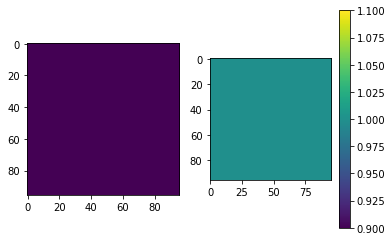

In [57]:
n=89
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_mask[n,:,:,0])
plt.subplot(1,2,2)
plt.imshow(img_maskf[n,:,:,1])
plt.colorbar()
plt.show()

In [58]:
print(np.asarray(mask_ROI_F).shape)

(2141, 96, 96, 2)


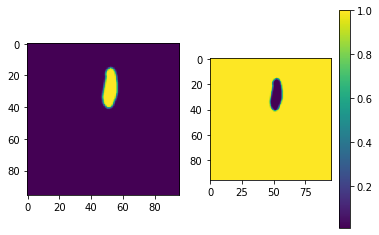

In [59]:
n=540
plt.figure()
plt.subplot(1,2,1)
plt.imshow(mask_ROI_F[n,:,:,0])
plt.subplot(1,2,2)
plt.imshow(mask_ROI_F[n,:,:,1])
plt.colorbar()
plt.show()

(96, 96, 1)


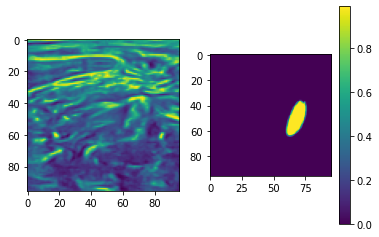

In [63]:
print(img_ROI1[73].shape)
n=67
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_ROI1[n])
plt.subplot(1,2,2)
plt.imshow(mask_ROI1[n])
plt.colorbar()
plt.show()

In [16]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    #Drop1 = Dropout(0.5)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    #Drop1 = Dropout(0.5)
    
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    #Drop1 = Dropout(0.5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    #Drop1 = Dropout(0.5)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    
    #Drop1 = Dropout(0.5)
    

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    #conv10 = Conv2D(1, (1, 1), activation='relu')(conv9)
    
    conv10 = Conv2D(2, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer= Adam(lr=1e-3), loss= [tensorflow.keras.losses.binary_crossentropy], metrics=[dice_coef_multilabel])

    return model

model = get_unet()

model_Early= EarlyStopping(monitor="val_dice_coef_multilabel", patience=10, verbose=2, mode="max")

model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_dice_coef_multilabel', mode="max", save_best_only=True)


#history = model.fit(img_train, img_maskf, batch_size=32, epochs=5,  verbose=1, shuffle=True,
#            validation_split=0.2, callbacks=[model_checkpoint, model_Early])

history = model.fit(np.asarray(img_ROI1), mask_ROI_F, batch_size=32, epochs=20,  verbose=1, shuffle=True,
              validation_split=0.2, callbacks=[model_checkpoint, model_Early])

Epoch 1/20
54/54 [==============================] - 267s 5s/step - loss: 0.2067 - dice_coef_multilabel: 0.4813 - val_loss: 0.1305 - val_dice_coef_multilabel: 0.5015
Epoch 2/20
54/54 [==============================] - 296s 5s/step - loss: 0.1279 - dice_coef_multilabel: 0.5072 - val_loss: 0.1101 - val_dice_coef_multilabel: 0.5157
Epoch 3/20
54/54 [==============================] - 245s 5s/step - loss: 0.0840 - dice_coef_multilabel: 0.5870 - val_loss: 0.0747 - val_dice_coef_multilabel: 0.6326
Epoch 4/20
54/54 [==============================] - 237s 4s/step - loss: 0.0705 - dice_coef_multilabel: 0.6328 - val_loss: 0.0698 - val_dice_coef_multilabel: 0.6551
Epoch 5/20
54/54 [==============================] - 234s 4s/step - loss: 0.0653 - dice_coef_multilabel: 0.6528 - val_loss: 0.0684 - val_dice_coef_multilabel: 0.6562
Epoch 6/20
54/54 [==============================] - 255s 5s/step - loss: 0.0580 - dice_coef_multilabel: 0.6931 - val_loss: 0.0589 - val_dice_coef_multilabel: 0.6884
Epoch 7/20

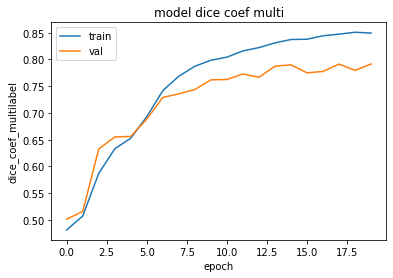

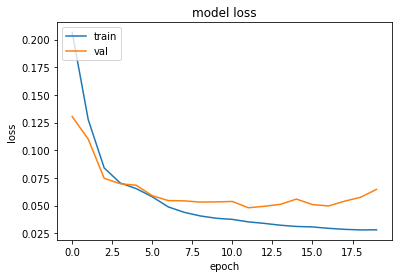

In [64]:
#list all data in history
#print(history.history)
#summarize history for accuracy
plt.figure()
plt.plot(history.history["dice_coef_multilabel"])
plt.plot(history.history["val_dice_coef_multilabel"])
plt.title('model dice coef multi')
plt.ylabel("dice_coef_multilabel")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()
#summarize history for loss
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('model loss')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [18]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 48, 32)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [65]:
predict = model.predict(img_train[801:])

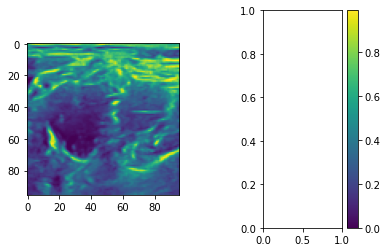

In [66]:
num=93
#result= predict[num][:,:,0]
#predict[predict>=0.7]=1
#predict[predict<0.7]=0  1   802

plt.figure()  
plt.subplot(1,2,1)
plt.imshow(img_train[num+801])
plt.subplot(1,2,2)
plt.imshow(img_maskf[num+801,:,:,0])
plt.subplot(1,3,3)
plt.colorbar()
plt.show()

In [21]:
g=0
for i in predict[:,:,:,0]:
    if np.asarray(i).sum()!=0:
        g+=1
print(g)

4434


In [22]:
predict = model.predict(np.asarray(img_ROI1[801:]))

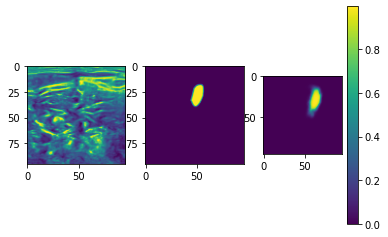

In [67]:
num=76
#result= predict[num][:,:,0]
#predict[predict>=0.7]=1
#predict[predict<0.7]=0  1   802

plt.figure()  
plt.subplot(1,3,1)
plt.imshow(img_ROI1[num+801])
plt.subplot(1,3,2)
plt.imshow(mask_ROI_F[num+801,:,:,0])
plt.subplot(1,3,3)
plt.imshow(predict[num,:,:,0])
plt.colorbar()
plt.show()

In [69]:
num=69
#result= predict[num][:,:,0]
#predict[predict>=0.7]=1
#predict[predict<0.7]=0  1   802

plt.figure()  
plt.subplot(1,2,1)
plt.imshow(img_train[num+801])
plt.subplot(1,2,2)
plt.imshow(predict[num])
plt.colorbar()
plt.show()

TypeError: Invalid shape (96, 96, 2) for image data

In [70]:
model.evaluate(np.asarray(img_ROI_test), test_mask_ROI_F)

6/6 [==============================] - 4s 724ms/step - loss: 0.0795 - dice_coef_multilabel: 0.7706


[0.07946864515542984, 0.7705660462379456]

In [71]:
model.save("modelok")

INFO:tensorflow:Assets written to: modelok\assets


In [73]:
modelok = keras.models.load_model("weights.h5", custom_objects={'dice_coef_multilabel':dice_coef_multilabel})

In [74]:
predict=model.predict(np.asarray(img_ROI_test))

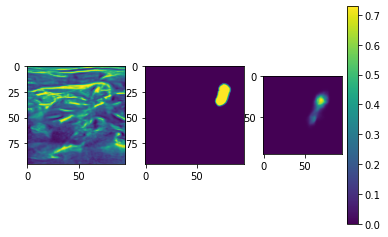

In [75]:
num=30

plt.figure()  
plt.subplot(1,3,1)
plt.imshow(img_ROI_test[num])
plt.subplot(1,3,2)
plt.imshow(test_mask_ROI_F[num,:,:,0])
plt.subplot(1,3,3)
plt.imshow(predict[num,:,:,0])
plt.colorbar()
plt.show()